In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torchvision import datasets, transforms,models
import matplotlib.pyplot as plt
import timm
import numpy as np


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [4]:
IMG_SIZE = 224
BATCH_SIZE = 32

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])



In [5]:
train_dataset = datasets.ImageFolder("dataset/train", transform=train_transform)
val_dataset   = datasets.ImageFolder("dataset/valid", transform=val_test_transform)


train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)


class_names = train_dataset.classes
num_classes = len(class_names)
print("Classes:", class_names)

Classes: ['1', '10', '100', '101', '102', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '9', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99']


In [ ]:
# Flower names mapping 
flower_names = [
    'pink primrose', 'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea', 'english marigold',
    'tiger lily', 'moon orchid', 'bird of paradise', 'monkshood', 'globe thistle',
    'snapdragon', "colt's foot", 'king protea', 'spear thistle', 'yellow iris',
    'globe-flower', 'purple coneflower', 'peruvian lily', 'balloon flower', 'giant white arum lily',
    'fire lily', 'pincushion flower', 'fritillary', 'red ginger', 'grape hyacinth',
    'corn poppy', 'prince of wales feathers', 'stemless gentian', 'artichoke', 'sweet william',
    'carnation', 'garden phlox', 'love in the mist', 'mexican aster', 'alpine sea holly',
    'ruby-lipped cattleya', 'cape flower', 'great masterwort', 'siam tulip', 'lenten rose',
    'barbeton daisy', 'daffodil', 'sword lily', 'poinsettia', 'bolero deep blue', 'wallflower',
    'marigold', 'buttercup', 'oxeye daisy', 'common dandelion', 'petunia', 'wild pansy',
    'primula', 'sunflower', 'pelargonium', 'bishop of llandaff', 'gaura', 'geranium',
    'orange dahlia', 'pink-yellow dahlia', 'cautleya spicata', 'japanese anemone', 'black-eyed susan',
    'silverbush', 'californian poppy', 'osteospermum', 'spring crocus', 'bearded iris',
    'windflower', 'tree poppy', 'gazania', 'azalea', 'water lily', 'rose',
    'thorn apple', 'morning glory', 'passion flower', 'lotus', 'toad lily',
    'anthurium', 'frangipani', 'clematis', 'hibiscus', 'columbine',
    'desert-rose', 'tree mallow', 'magnolia', 'cyclamen', 'watercress',
    'canna lily', 'hippeastrum', 'bee balm', 'ball moss', 'foxglove',
    'bougainvillea', 'camellia', 'mallow', 'mexican petunia', 'bromelia',
    'blanket flower', 'trumpet creeper', 'blackberry lily'
]

# Create mapping from class index to flower name
idx_to_flower = {i: flower_names[i] for i in range(len(flower_names))}

print(f"✅ Loaded {len(flower_names)} flower names")
print(f"\nExample mappings:")
for i in range(5):
    print(f"  Class {i}: {flower_names[i]}")

✅ Loaded 102 flower names

Example mappings:
  Class 0: pink primrose
  Class 1: hard-leaved pocket orchid
  Class 2: canterbury bells
  Class 3: sweet pea
  Class 4: english marigold


In [20]:
print(f"model pre-trained: {'convnext_base'}...")

model = models.get_model('convnext_base', weights='IMAGENET1K_V1')

for param in model.parameters():
    param.requires_grad = False


num_ftrs = model.classifier[-1].in_features


model.classifier[-1] = nn.Linear(num_ftrs, num_classes)


model = model.to(device)

model pre-trained: convnext_base...


In [21]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [22]:
from tqdm import tqdm

EPOCHS = 5

train_acc_list, val_acc_list = [], []
train_loss_list, val_loss_list = [], []

for epoch in range(EPOCHS):
    model.train()
    correct, total = 0, 0
    train_loss = 0

    # Training progress bar
    train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{EPOCHS} [Train]', ncols=100)
    for images, labels in train_pbar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Update progress bar with current accuracy
        train_pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{correct/total:.4f}'})

    train_acc = correct / total
    avg_train_loss = train_loss / len(train_loader)
    train_acc_list.append(train_acc)
    train_loss_list.append(avg_train_loss)

    # Validation progress bar
    model.eval()
    correct, total = 0, 0
    val_loss = 0

    val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{EPOCHS} [Val]  ', ncols=100)
    with torch.no_grad():
        for images, labels in val_pbar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Update progress bar with current accuracy
            val_pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{correct/total:.4f}'})

    val_acc = correct / total
    avg_val_loss = val_loss / len(val_loader)
    val_acc_list.append(val_acc)
    val_loss_list.append(avg_val_loss)

    print(f"\n📊 Epoch [{epoch+1}/{EPOCHS}] Summary: "
          f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f}\n")

Epoch 1/15 [Val]  : 100%|██████████████████| 26/26 [00:10<00:00,  2.47it/s, loss=0.9290, acc=0.8362]


Epoch 1/15 [Val]  : 100%|██████████████████| 26/26 [00:10<00:00,  2.47it/s, loss=0.9290, acc=0.8362]



📊 Epoch [1/15] Summary: Train Loss: 2.4264, Train Acc: 0.5719 | Val Loss: 1.0983, Val Acc: 0.8362



Epoch 2/15 [Val]  : 100%|██████████████████| 26/26 [00:10<00:00,  2.49it/s, loss=0.4717, acc=0.9059]


Epoch 1/15 [Val]  : 100%|██████████████████| 26/26 [00:10<00:00,  2.47it/s, loss=0.9290, acc=0.8362]



📊 Epoch [1/15] Summary: Train Loss: 2.4264, Train Acc: 0.5719 | Val Loss: 1.0983, Val Acc: 0.8362



Epoch 2/15 [Val]  : 100%|██████████████████| 26/26 [00:10<00:00,  2.49it/s, loss=0.4717, acc=0.9059]



📊 Epoch [2/15] Summary: Train Loss: 0.8812, Train Acc: 0.8777 | Val Loss: 0.6030, Val Acc: 0.9059



Epoch 3/15 [Val]  : 100%|██████████████████| 26/26 [00:10<00:00,  2.43it/s, loss=0.3059, acc=0.9242]


Epoch 1/15 [Val]  : 100%|██████████████████| 26/26 [00:10<00:00,  2.47it/s, loss=0.9290, acc=0.8362]



📊 Epoch [1/15] Summary: Train Loss: 2.4264, Train Acc: 0.5719 | Val Loss: 1.0983, Val Acc: 0.8362



Epoch 2/15 [Val]  : 100%|██████████████████| 26/26 [00:10<00:00,  2.49it/s, loss=0.4717, acc=0.9059]



📊 Epoch [2/15] Summary: Train Loss: 0.8812, Train Acc: 0.8777 | Val Loss: 0.6030, Val Acc: 0.9059



Epoch 3/15 [Val]  : 100%|██████████████████| 26/26 [00:10<00:00,  2.43it/s, loss=0.3059, acc=0.9242]



📊 Epoch [3/15] Summary: Train Loss: 0.5340, Train Acc: 0.9292 | Val Loss: 0.4373, Val Acc: 0.9242



Epoch 4/15 [Val]  : 100%|██████████████████| 26/26 [00:11<00:00,  2.28it/s, loss=0.2489, acc=0.9389]


Epoch 1/15 [Val]  : 100%|██████████████████| 26/26 [00:10<00:00,  2.47it/s, loss=0.9290, acc=0.8362]



📊 Epoch [1/15] Summary: Train Loss: 2.4264, Train Acc: 0.5719 | Val Loss: 1.0983, Val Acc: 0.8362



Epoch 2/15 [Val]  : 100%|██████████████████| 26/26 [00:10<00:00,  2.49it/s, loss=0.4717, acc=0.9059]



📊 Epoch [2/15] Summary: Train Loss: 0.8812, Train Acc: 0.8777 | Val Loss: 0.6030, Val Acc: 0.9059



Epoch 3/15 [Val]  : 100%|██████████████████| 26/26 [00:10<00:00,  2.43it/s, loss=0.3059, acc=0.9242]



📊 Epoch [3/15] Summary: Train Loss: 0.5340, Train Acc: 0.9292 | Val Loss: 0.4373, Val Acc: 0.9242



Epoch 4/15 [Val]  : 100%|██████████████████| 26/26 [00:11<00:00,  2.28it/s, loss=0.2489, acc=0.9389]



📊 Epoch [4/15] Summary: Train Loss: 0.3900, Train Acc: 0.9461 | Val Loss: 0.3489, Val Acc: 0.9389



Epoch 5/15 [Train]:   2%|▍                 | 5/205 [00:02<01:54,  1.74it/s, loss=0.2154, acc=0.9750]


Epoch 1/15 [Val]  : 100%|██████████████████| 26/26 [00:10<00:00,  2.47it/s, loss=0.9290, acc=0.8362]



📊 Epoch [1/15] Summary: Train Loss: 2.4264, Train Acc: 0.5719 | Val Loss: 1.0983, Val Acc: 0.8362



Epoch 2/15 [Val]  : 100%|██████████████████| 26/26 [00:10<00:00,  2.49it/s, loss=0.4717, acc=0.9059]



📊 Epoch [2/15] Summary: Train Loss: 0.8812, Train Acc: 0.8777 | Val Loss: 0.6030, Val Acc: 0.9059



Epoch 3/15 [Val]  : 100%|██████████████████| 26/26 [00:10<00:00,  2.43it/s, loss=0.3059, acc=0.9242]



📊 Epoch [3/15] Summary: Train Loss: 0.5340, Train Acc: 0.9292 | Val Loss: 0.4373, Val Acc: 0.9242



Epoch 4/15 [Val]  : 100%|██████████████████| 26/26 [00:11<00:00,  2.28it/s, loss=0.2489, acc=0.9389]



📊 Epoch [4/15] Summary: Train Loss: 0.3900, Train Acc: 0.9461 | Val Loss: 0.3489, Val Acc: 0.9389



Epoch 5/15 [Train]:   2%|▍                 | 5/205 [00:02<01:54,  1.74it/s, loss=0.2154, acc=0.9750]


KeyboardInterrupt: 

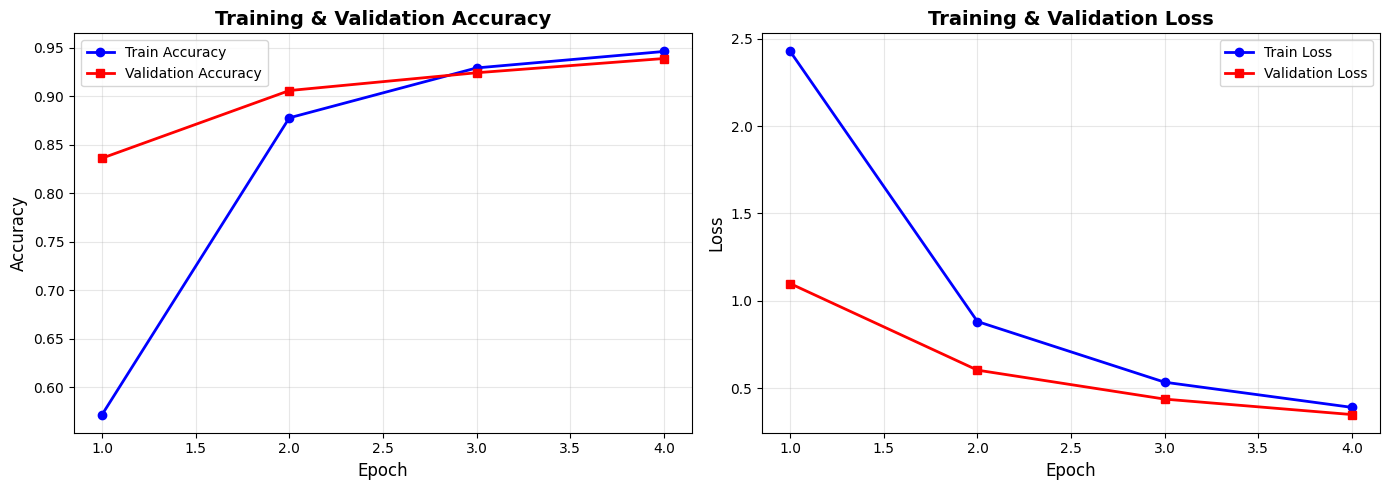


📈 TRAINING COMPLETE
Best Training Accuracy:   0.9461 (Epoch 4)
Best Validation Accuracy: 0.9389 (Epoch 4)
Final Training Accuracy:   0.9461
Final Validation Accuracy: 0.9389


In [23]:
# Plot Training Progress
plt.figure(figsize=(14, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_acc_list) + 1), train_acc_list, 'b-o', label='Train Accuracy', linewidth=2)
plt.plot(range(1, len(val_acc_list) + 1), val_acc_list, 'r-s', label='Validation Accuracy', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Training & Validation Accuracy', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_loss_list) + 1), train_loss_list, 'b-o', label='Train Loss', linewidth=2)
plt.plot(range(1, len(val_loss_list) + 1), val_loss_list, 'r-s', label='Validation Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training & Validation Loss', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final metrics
print(f"\n{'='*60}")
print(f"📈 TRAINING COMPLETE")
print(f"{'='*60}")
print(f"Best Training Accuracy:   {max(train_acc_list):.4f} (Epoch {train_acc_list.index(max(train_acc_list)) + 1})")
print(f"Best Validation Accuracy: {max(val_acc_list):.4f} (Epoch {val_acc_list.index(max(val_acc_list)) + 1})")
print(f"Final Training Accuracy:   {train_acc_list[-1]:.4f}")
print(f"Final Validation Accuracy: {val_acc_list[-1]:.4f}")
print(f"{'='*60}")

🔍 Testing model on validation dataset...



Testing: 100%|██████████████████████████████████████████| 26/26 [00:11<00:00,  2.27it/s, acc=0.9364]



✅ TEST RESULTS
Test Accuracy: 93.64%
Correct Predictions: 766/818

🌸 Sample Predictions (with flower names):
✅ Predicted: pink primrose                  | Actual: pink primrose
✅ Predicted: pink primrose                  | Actual: pink primrose
✅ Predicted: pink primrose                  | Actual: pink primrose
✅ Predicted: pink primrose                  | Actual: pink primrose
✅ Predicted: pink primrose                  | Actual: pink primrose
✅ Predicted: pink primrose                  | Actual: pink primrose
✅ Predicted: pink primrose                  | Actual: pink primrose
✅ Predicted: pink primrose                  | Actual: pink primrose
✅ Predicted: hard-leaved pocket orchid      | Actual: hard-leaved pocket orchid
✅ Predicted: hard-leaved pocket orchid      | Actual: hard-leaved pocket orchid

🖼️  Visualizing Sample Predictions...


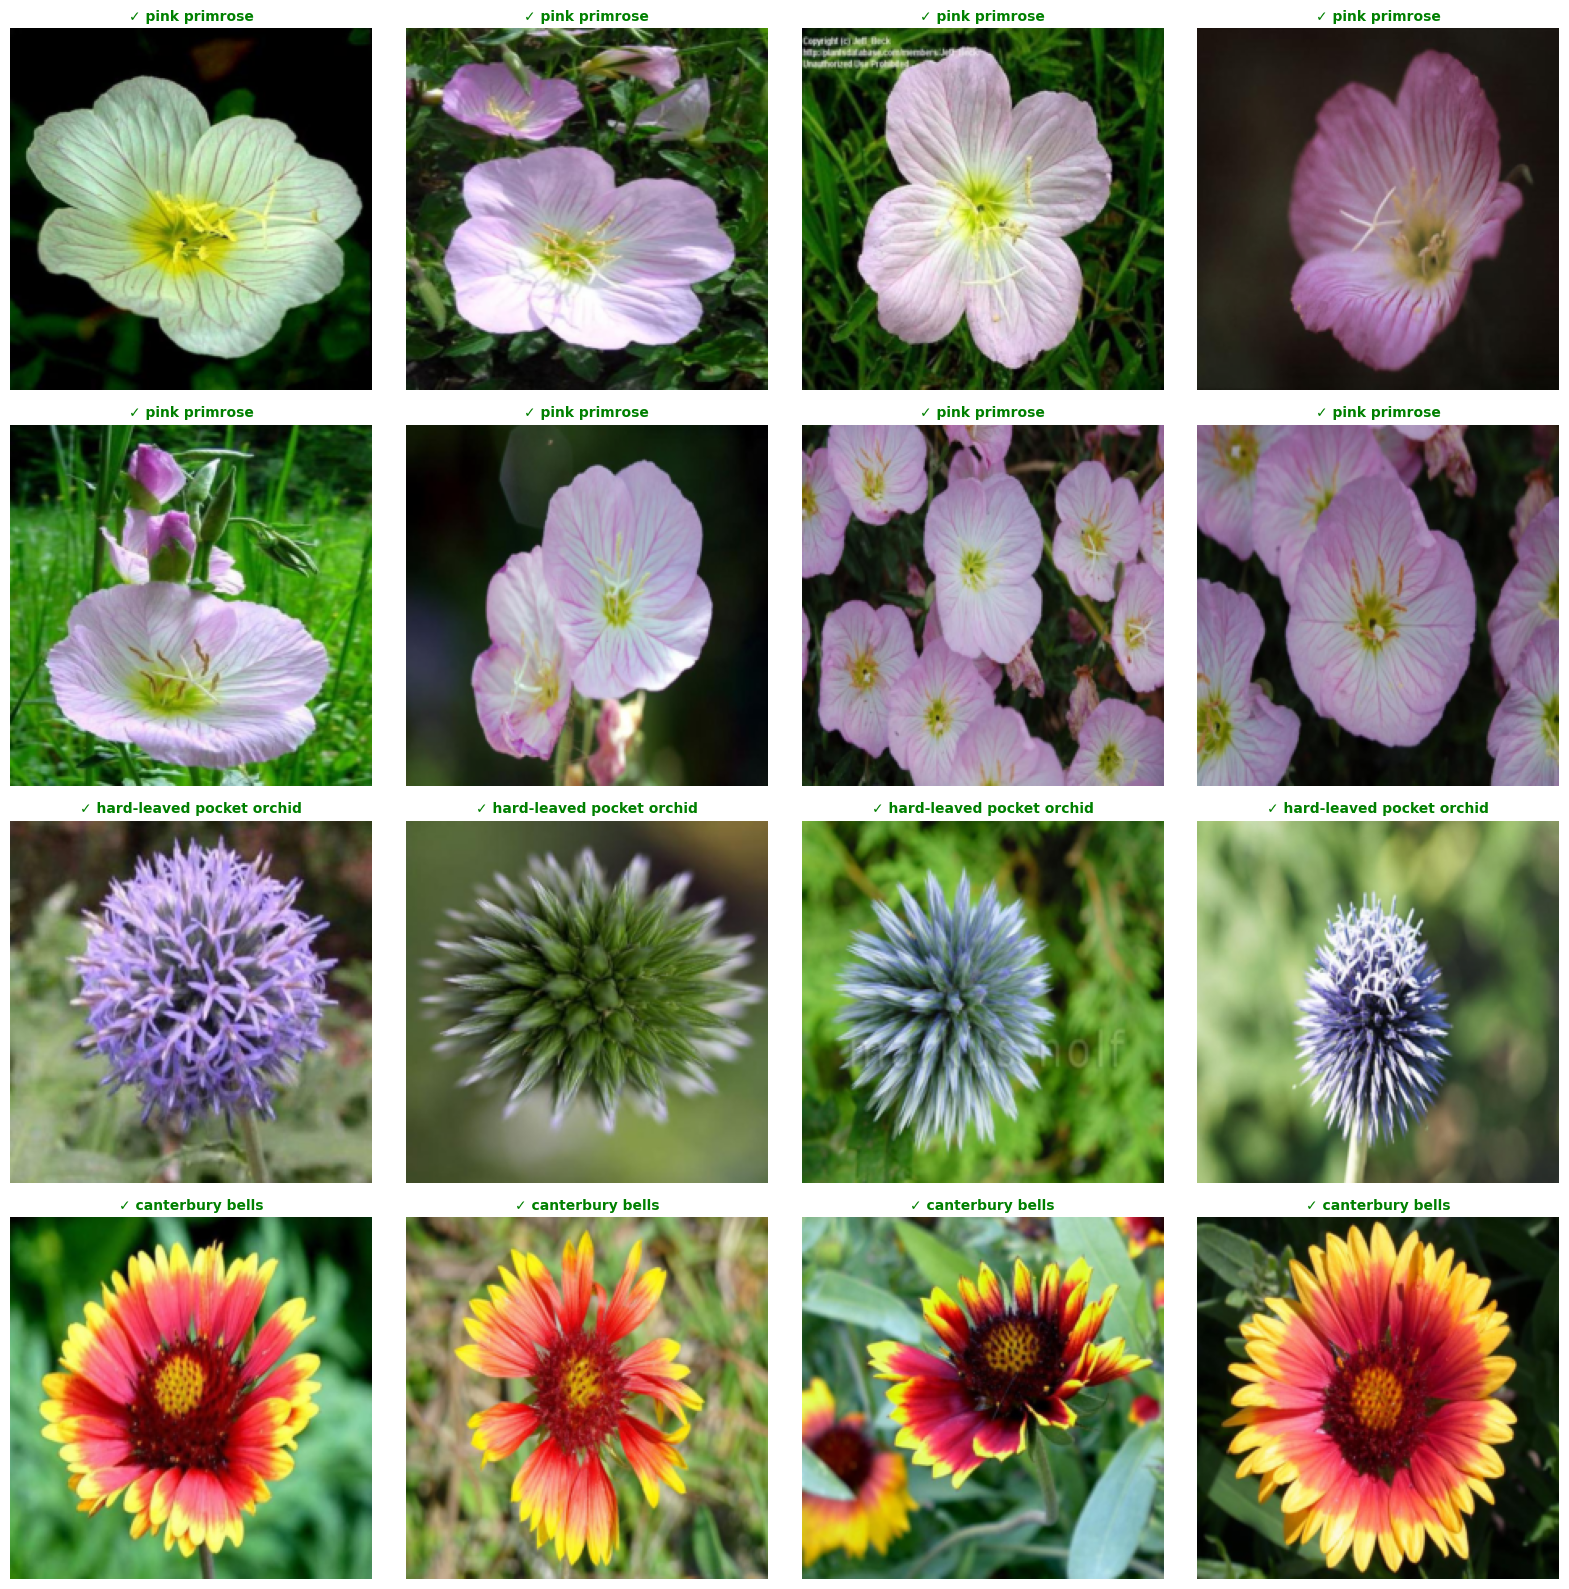

✅ Visualization complete!


In [39]:
# Test the model on validation dataset
model.eval()
correct = 0
total = 0
all_predictions = []
all_labels = []
all_images = []

print("🔍 Testing model on validation dataset...\n")
test_pbar = tqdm(val_loader, desc='Testing', ncols=100)

with torch.no_grad():
    for images, labels in test_pbar:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Store first batch of images for visualization
        if len(all_images) == 0:
            all_images = images[:16].cpu()  # Store first 16 images
        
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        
        # Update progress bar
        test_pbar.set_postfix({'acc': f'{correct/total:.4f}'})

test_accuracy = 100 * correct / total

print(f"\n{'='*60}")
print(f"✅ TEST RESULTS")
print(f"{'='*60}")
print(f"Test Accuracy: {test_accuracy:.2f}%")
print(f"Correct Predictions: {correct}/{total}")
print(f"{'='*60}")

# Show some example predictions with flower names
print(f"\n🌸 Sample Predictions (with flower names):")
print("="*60)
for i in range(min(10, len(all_predictions))):
    pred_name = flower_names[all_predictions[i]]
    true_name = flower_names[all_labels[i]]
    status = "✅" if all_predictions[i] == all_labels[i] else "❌"
    print(f"{status} Predicted: {pred_name:30s} | Actual: {true_name}")
print("="*60)

# Visualize predictions with images
def denormalize(tensor):
    """Denormalize image tensor for visualization"""
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return tensor * std + mean

print("\n🖼️  Visualizing Sample Predictions...")
fig, axes = plt.subplots(4, 4, figsize=(16, 16))
axes = axes.ravel()

for idx in range(min(16, len(all_images))):
    # Denormalize and convert to numpy
    img = denormalize(all_images[idx])
    img = img.permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)
    
    # Get prediction and label
    pred_idx = all_predictions[idx]
    true_idx = all_labels[idx]
    pred_name = flower_names[pred_idx]
    true_name = flower_names[true_idx]
    
    # Plot
    axes[idx].imshow(img)
    axes[idx].axis('off')
    
    # Set title with color (green for correct, red for incorrect)
    is_correct = pred_idx == true_idx
    color = 'green' if is_correct else 'red'
    title = f"✓ {pred_name}" if is_correct else f"✗ Pred: {pred_name}\nTrue: {true_name}"
    axes[idx].set_title(title, fontsize=10, color=color, weight='bold')

plt.tight_layout()
plt.show()

print("✅ Visualization complete!")